In [1]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow.keras import models, layers, utils, backend as K
import shap
from tensorflow.keras.utils import plot_model


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # viz
import matplotlib.pyplot as plt # viz
from scipy import stats
import json
from typing import List, Tuple

from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn import metrics, linear_model

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

In [3]:
#Load Data
#train_df = pd.read_csv('labelled_training_data.csv')
#test_df = pd.read_csv('labelled_testing_data.csv')
#validation_df = pd.read_csv('labelled_validation_data.csv')

train_df = pd.read_excel("labelled_training_data_2.xlsx")
test_df = pd.read_excel("labelled_testing_data_2.xlsx")
validation_df = pd.read_excel("labelled_validation_data_2.xlsx")

In [4]:
#Check all of the columns are the same across all three dataframes
assert train_df.columns.all() == test_df.columns.all() == validation_df.columns.all()

In [5]:
train_df.dtypes

timestamp          float64
processId            int64
threadId             int64
parentProcessId      int64
userId               int64
mountNamespace       int64
processName         object
hostName            object
eventId              int64
eventName           object
stackAddresses      object
argsNum              int64
returnValue          int64
args                object
sus                  int64
evil                 int64
dtype: object

In [6]:
#Visual Inspection / Summary
train_df.head()

,timestamp,processId,threadId,parentProcessId,userId,mountNamespace,processName,hostName,eventId,eventName,stackAddresses,argsNum,returnValue,args,sus,evil
0,1809.495787,381,7337,1,100,4026532231,close,ip-10-100-1-120,157,prctl,"[140662171848350, 11649800180280676]",5,0,"[{'name': 'option', 'type': 'int', 'value': 'P...",1,0
1,1809.495832,381,7337,1,100,4026532231,close,ip-10-100-1-120,3,close,[140662171777451],1,0,"[{'name': 'fd', 'type': 'int', 'value': 19}]",1,0
2,1809.495921,381,7337,1,100,4026532231,close,ip-10-100-1-120,1010,sched_process_exit,[],0,0,[],1,0
3,1894.139651,7347,7347,7341,0,4026531840,sh,ip-10-100-1-120,21,access,[],2,-2,"[{'name': 'pathname', 'type': 'const char*', '...",1,0
4,1894.142127,7347,7347,7341,0,4026531840,sh,ip-10-100-1-120,1005,security_file_open,"[139778263990104, 139778263906698]",4,0,"[{'name': 'pathname', 'type': 'const char*', '...",1,0


In [7]:
train_df.describe(include=['object', 'float', 'int'])

,timestamp,processId,threadId,parentProcessId,userId,mountNamespace,processName,hostName,eventId,eventName,stackAddresses,argsNum,returnValue,args,sus,evil
count,14737.000000,14737.000000,14737.000000,14737.000000,14737.000000,1.473700e+04,14737,14737,14737.000000,14737,14737,14737.000000,14737.000000,14737,14737.000000,14737.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,26,7,NaN,26,3349,NaN,NaN,6430,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,ps,ip-10-100-1-120,NaN,openat,[],NaN,NaN,"[{'name': 'fd', 'type': 'int', 'value': 9}]",NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,11125,13757,NaN,4018,9125,NaN,NaN,2891,NaN,NaN
mean,400.900624,5972.684807,5995.066092,1117.978082,68.581937,4.026532e+09,NaN,NaN,346.319943,NaN,NaN,2.782656,19.375653,NaN,0.086110,0.0
std,283.601735,2704.426603,2685.236842,960.620060,250.970333,4.861497e+01,NaN,NaN,412.502990,NaN,NaN,1.357931,311.138087,NaN,0.280536,0.0
min,133.669458,1.000000,1.000000,0.000000,0.000000,4.026532e+09,NaN,NaN,3.000000,NaN,NaN,0.000000,-115.000000,NaN,0.000000,0.0
25%,149.941155,7276.000000,7276.000000,1317.000000,0.000000,4.026532e+09,NaN,NaN,3.000000,NaN,NaN,1.000000,0.000000,NaN,0.000000,0.0
50%,336.585513,7281.000000,7281.000000,1317.000000,0.000000,4.026532e+09,NaN,NaN,257.000000,NaN,NaN,4.000000,0.000000,NaN,0.000000,0.0
75%,585.201152,7295.000000,7295.000000,1317.000000,0.000000,4.026532e+09,NaN,NaN,1005.000000,NaN,NaN,4.000000,3.000000,NaN,0.000000,0.0


<AxesSubplot:title={'center':'Label Frequency for evil label in Train Dataset'}>

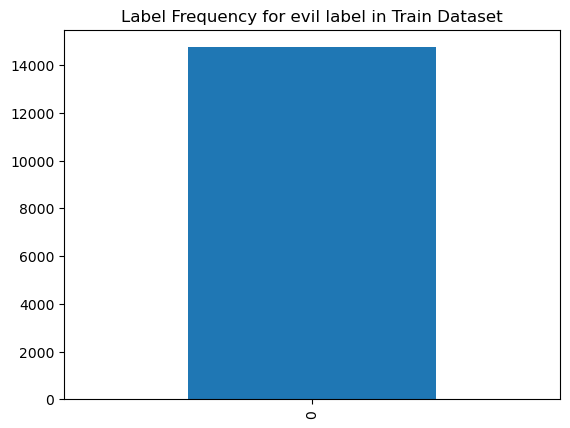

In [8]:
#EDA
train_df.evil.value_counts().plot(kind='bar', title='Label Frequency for evil label in Train Dataset')

<AxesSubplot:title={'center':'Label Frequency for sus label in Train Dataset'}>

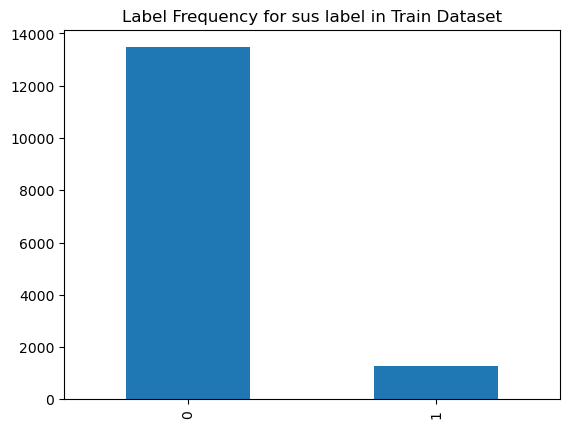

In [9]:
train_df.sus.value_counts().plot(kind='bar', title='Label Frequency for sus label in Train Dataset')

<AxesSubplot:title={'center':'Label Frequency for evil label in Test Dataset'}>

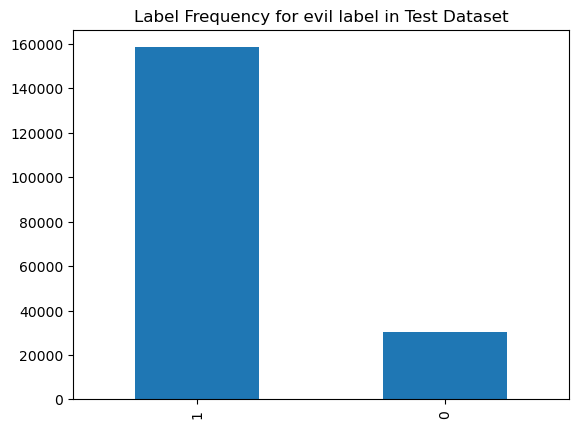

In [9]:
test_df.evil.value_counts().plot(kind='bar', title='Label Frequency for evil label in Test Dataset')

<AxesSubplot:title={'center':'Label Frequency for sus label in Test Dataset'}>

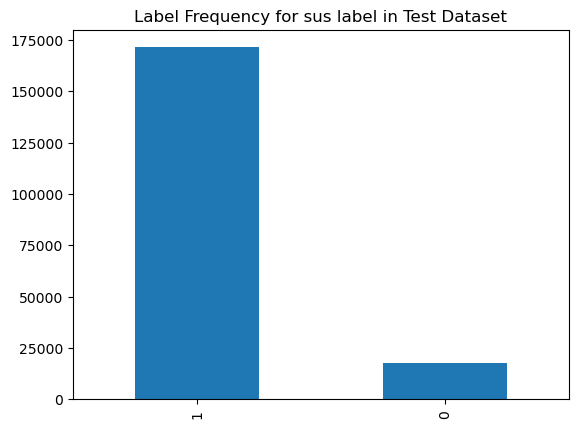

In [10]:
test_df.sus.value_counts().plot(kind='bar', title='Label Frequency for sus label in Test Dataset')

<AxesSubplot:title={'center':'Label Frequency for evil label in Validation Dataset'}>

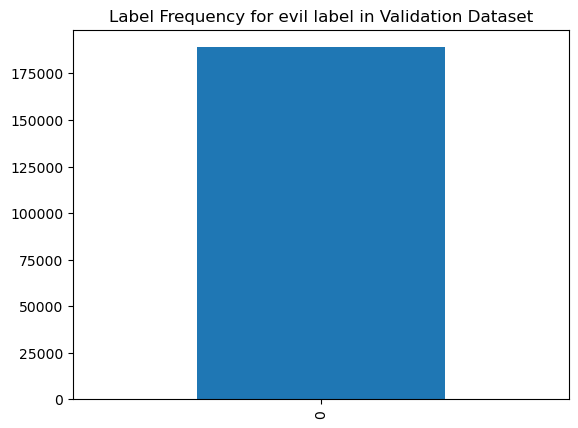

In [11]:
validation_df.evil.value_counts().plot(kind='bar', title='Label Frequency for evil label in Validation Dataset')

<AxesSubplot:title={'center':'Label Frequency for sus label in Validation Dataset'}>

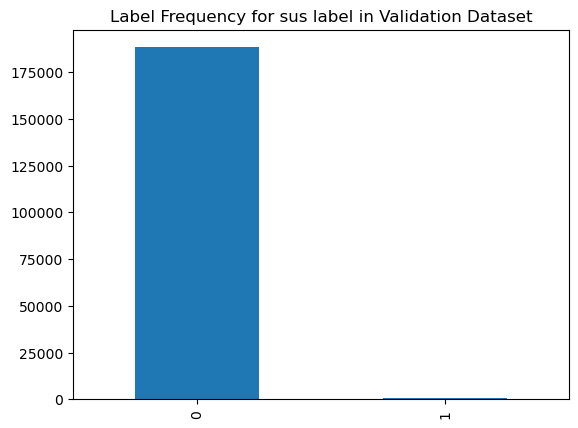

In [12]:
validation_df.sus.value_counts().plot(kind='bar', title='Label Frequency for sus label in Validation Dataset')

In [13]:
train_df.groupby(['sus', 'evil'])[['timestamp']].count()

,,timestamp
sus,evil,
0,0,761875
1,0,1269


<AxesSubplot:xlabel='sus,evil'>

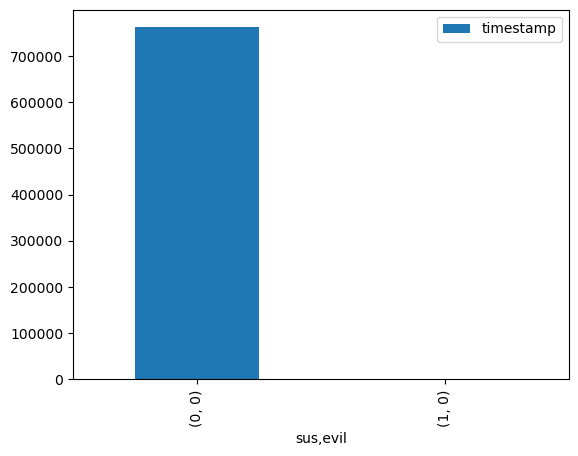

In [14]:
train_df.groupby(['sus', 'evil'])[['timestamp']].count().plot(kind='bar')

In [15]:
test_df.groupby(['sus', 'evil'])[['timestamp']].count()

timestamp
sus evil           
0   0         17508
1   0         13027
    1        158432

In [16]:
test_df.loc[(test_df['sus'] == 1) & (test_df['evil'] == 1)].shape[0]

158432

<AxesSubplot:xlabel='sus,evil'>

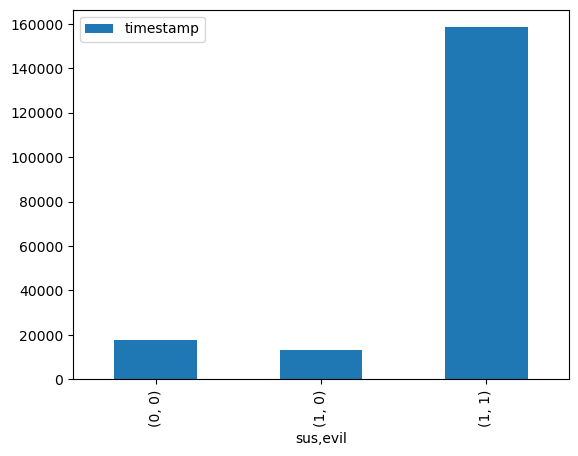

In [17]:
test_df.groupby(['sus', 'evil'])[['timestamp']].count().plot(kind='bar')

In [18]:
validation_df.groupby(['sus', 'evil'])[['timestamp']].count()

,,timestamp
sus,evil,
0,0,188181
1,0,786


<AxesSubplot:xlabel='sus,evil'>

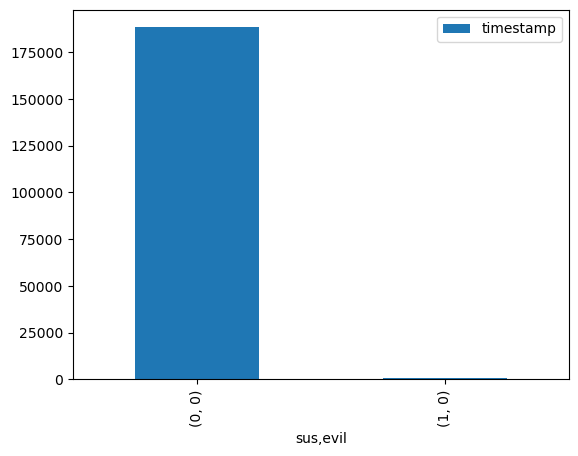

In [19]:
validation_df.groupby(['sus', 'evil'])[['timestamp']].count().plot(kind='bar')

In [20]:
#¿Cuál es la correlación de características en cada conjunto de datos?
def dataset_to_corr_heatmap(dataframe, title, ax):
    corr = dataframe.corr()
    sns.heatmap(corr, ax = ax, annot=True, cmap="YlGnBu")
    ax.set_title(f'Correlation Plot for {title}')

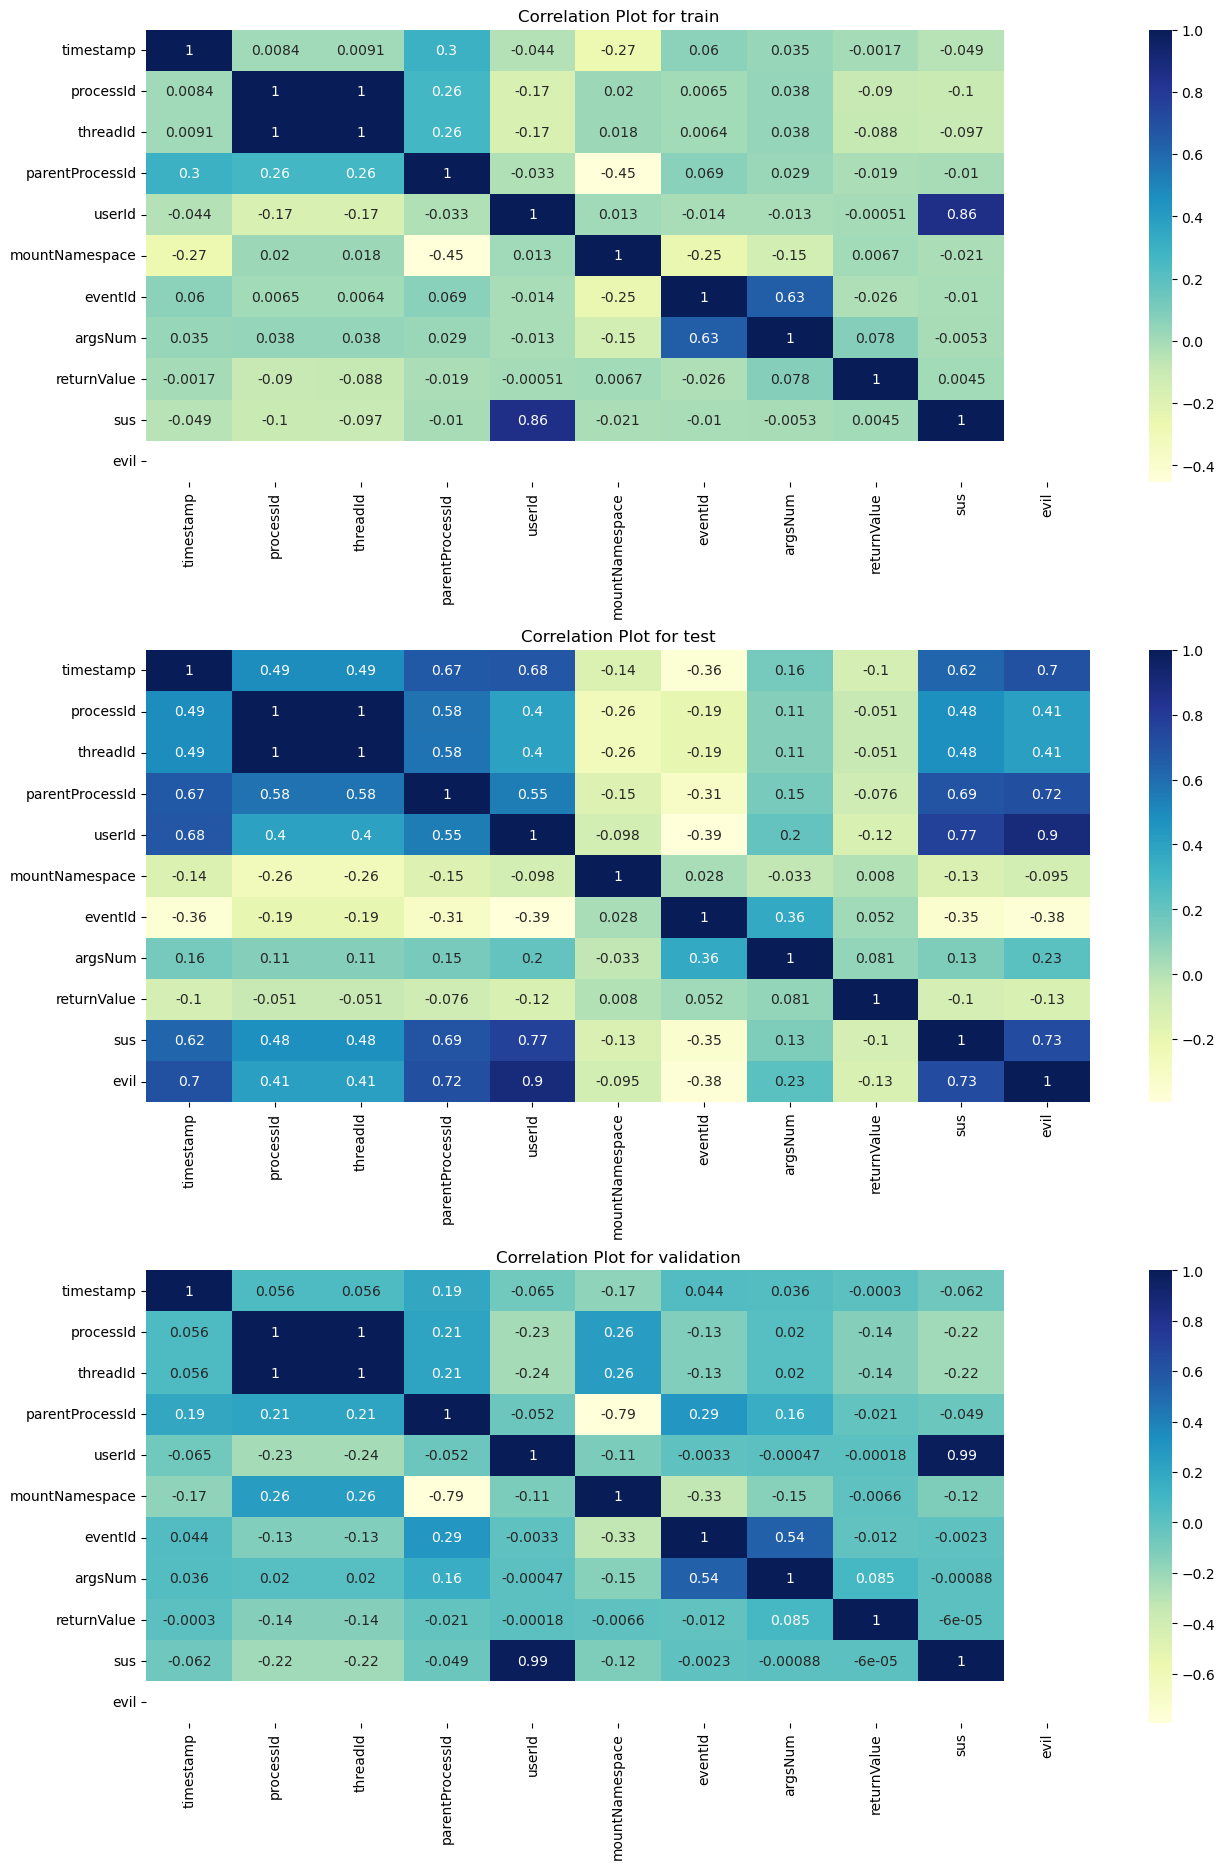

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (15,20))
fig.tight_layout(pad=10.0)
datasets = [train_df, test_df, validation_df]
dataset_names = ['train', 'test', 'validation']
axs = [ax1, ax2, ax3]

for dataset, name, ax in zip(datasets, dataset_names, axs):
    dataset_to_corr_heatmap(dataset, name, ax)

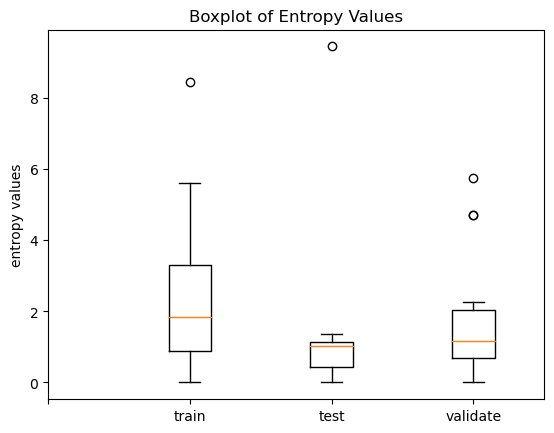

In [22]:
#Experimentando con otras formas de comparar los conjuntos de datos

#Entropy
datasets = [train_df, test_df, validation_df]

entropy_values = []
for dataset in datasets:
    dataset_entropy_values = []
    for col in dataset.columns:
        if col == 'timestamp':
            pass
        else:
            counts = dataset[col].value_counts()
            col_entropy = stats.entropy(counts)
            dataset_entropy_values.append(col_entropy)
            
    entropy_values.append(dataset_entropy_values)

plt.boxplot(entropy_values)
plt.title('Boxplot of Entropy Values')
plt.ylabel("entropy values")
plt.xticks([0,1,2,3],labels=['','train', 'test', 'validate'])
plt.show()

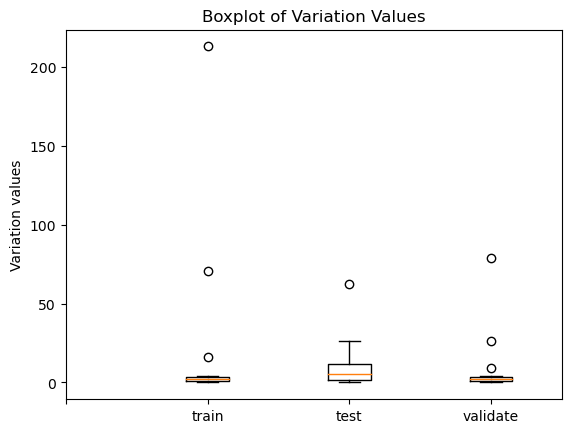

In [23]:
#Variation
datasets = [train_df, test_df, validation_df]

variation_values = []
for dataset in datasets:
    dataset_variation_values = []
    for col in dataset.columns:
        if col == 'timestamp':
            pass
        else:
            counts = dataset[col].value_counts()
            col_variation = stats.variation(counts)
            dataset_variation_values.append(col_variation)
            
    variation_values.append(dataset_variation_values)
    
plt.boxplot(variation_values)
plt.title('Boxplot of Variation Values')
plt.ylabel("Variation values")
plt.xticks([0,1,2,3],labels=['','train', 'test', 'validate'])
plt.show()

In [24]:
#Explorando las columnas no numéricas
train_df.loc[:, ['eventId', 'eventName']].head(10)

,eventId,eventName
0,157,prctl
1,3,close
2,1010,sched_process_exit
3,21,access
4,1005,security_file_open
5,257,openat
6,5,fstat
7,3,close
8,1005,security_file_open
9,257,openat


In [25]:
train_df.loc[:, ['processName', 'hostName', 'args']].head(10)

,processName,hostName,args
0,close,ip-10-100-1-120,"[{'name': 'option', 'type': 'int', 'value': 'P..."
1,close,ip-10-100-1-120,"[{'name': 'fd', 'type': 'int', 'value': 19}]"
2,close,ip-10-100-1-120,[]
3,sh,ip-10-100-1-120,"[{'name': 'pathname', 'type': 'const char*', '..."
4,sh,ip-10-100-1-120,"[{'name': 'pathname', 'type': 'const char*', '..."
5,sh,ip-10-100-1-120,"[{'name': 'dirfd', 'type': 'int', 'value': -10..."
6,sh,ip-10-100-1-120,"[{'name': 'fd', 'type': 'int', 'value': 3}, {'..."
7,sh,ip-10-100-1-120,"[{'name': 'fd', 'type': 'int', 'value': 3}]"
8,sh,ip-10-100-1-120,"[{'name': 'pathname', 'type': 'const char*', '..."
9,sh,ip-10-100-1-120,"[{'name': 'dirfd', 'type': 'int', 'value': -10..."


In [26]:
#Verificando los valores unicos para los tres campos anteriores
def column_uniques(df, col):
    print(f'{col} - Uniques:\n\n{df[col].unique()} \n\nNo. Uniques: {df[col].nunique()}')

In [27]:
column_uniques(train_df, 'processName')

processName - Uniques:

['close' 'sh' 'run-parts' 'atd' 'systemd-logind' 'systemd'
 'systemd-journal' 'dbus-daemon' '(time-dir)' 'systemd-user-ru' 'docker'
 'systemd-resolve' 'dockerd' 'containerd-shim' 'amazon-ssm-agen' 'ps'
 'cron' 'snapd' 'systemd-network' 'journal-offline' 'kworker/dying'
 'ssm-agent-worke' 'packagekitd' 'gdbus' 'gmain' '(tmpfiles)'
 'systemd-tmpfile' 'kworker/u30:1' 'poweroff' '(sd-sync)' 'kworker/u30:0'
 'kworker/u30:2' 'systemd-timesyn' 'systemd-udevd' '(sd-pam)' 'sshd'] 

No. Uniques: 36


In [28]:
column_uniques(train_df, 'hostName')

hostName - Uniques:

['ip-10-100-1-120' 'ip-10-100-1-173' 'ip-10-100-1-28' 'ip-10-100-1-34'
 'ip-10-100-1-55' 'ip-10-100-1-57' 'ip-10-100-1-79' 'ubuntu'] 

No. Uniques: 8


In [29]:
column_uniques(train_df, 'args')

args - Uniques:

["[{'name': 'option', 'type': 'int', 'value': 'PR_SET_NAME'}, {'name': 'arg2', 'type': 'unsigned long', 'value': 94819493392601}, {'name': 'arg3', 'type': 'unsigned long', 'value': 94819493392601}, {'name': 'arg4', 'type': 'unsigned long', 'value': 140662171848350}, {'name': 'arg5', 'type': 'unsigned long', 'value': 140662156379904}]"
 "[{'name': 'fd', 'type': 'int', 'value': 19}]" '[]' ...
 "[{'name': 'option', 'type': 'int', 'value': 'PR_SET_SECCOMP'}, {'name': 'arg2', 'type': 'unsigned long', 'value': 2}, {'name': 'arg3', 'type': 'unsigned long', 'value': 94764243566176}, {'name': 'arg4', 'type': 'unsigned long', 'value': 140537881935518}, {'name': 'arg5', 'type': 'unsigned long', 'value': 0}]"
 "[{'name': 'option', 'type': 'int', 'value': 'PR_SET_NO_NEW_PRIVS'}, {'name': 'arg2', 'type': 'unsigned long', 'value': 1}, {'name': 'arg3', 'type': 'unsigned long', 'value': 0}, {'name': 'arg4', 'type': 'unsigned long', 'value': 140537881935518}, {'name': 'arg5', 'type': 'u

In [30]:
column_uniques(test_df, 'args')

args - Uniques:

["[{'name': 'domain', 'type': 'int', 'value': 'AF_UNIX'}, {'name': 'type', 'type': 'int', 'value': 'SOCK_DGRAM|SOCK_CLOEXEC'}, {'name': 'protocol', 'type': 'int', 'value': 0}]"
 "[{'name': 'pathname', 'type': 'const char*', 'value': '/proc/382/cgroup'}, {'name': 'flags', 'type': 'int', 'value': 'O_RDONLY|O_LARGEFILE'}, {'name': 'dev', 'type': 'dev_t', 'value': 5}, {'name': 'inode', 'type': 'unsigned long', 'value': 38584}]"
 "[{'name': 'dirfd', 'type': 'int', 'value': -100}, {'name': 'pathname', 'type': 'const char*', 'value': '/proc/382/cgroup'}, {'name': 'flags', 'type': 'int', 'value': 'O_RDONLY|O_CLOEXEC'}, {'name': 'mode', 'type': 'int', 'value': 3335958308}]"
 ...
 '[{\'name\': \'sockfd\', \'type\': \'int\', \'value\': 422}, {\'name\': \'addr\', \'type\': \'struct sockaddr*\', \'value\': "{\'sin_port\': \'22\',\'sin_addr\': \'192.168.31.56\',\'sa_family\': \'AF_INET\'}"}, {\'name\': \'addrlen\', \'type\': \'int\', \'value\': 16}]'
 '[{\'name\': \'sockfd\', \'type

In [31]:
#This column looks very useful but also very messy. Let's create a small sub-sample and investigate futher
#Creando una pequeña muestra de 15 filas aleatorias
sample = train_df['args'].sample(n=15, random_state=1)
sample

177122          [{'name': 'fd', 'type': 'int', 'value': 9}]
373280    [{'name': 'cap', 'type': 'int', 'value': 'CAP_...
308561    [{'name': 'dirfd', 'type': 'int', 'value': -10...
5304      [{'name': 'pathname', 'type': 'const char*', '...
443058    [{'name': 'pathname', 'type': 'const char*', '...
30792           [{'name': 'fd', 'type': 'int', 'value': 9}]
696842    [{'name': 'oldfd', 'type': 'int', 'value': 5},...
231563    [{'name': 'dirfd', 'type': 'int', 'value': -10...
596975    [{'name': 'fd', 'type': 'unsigned int', 'value...
194924    [{'name': 'pathname', 'type': 'const char*', '...
246369    [{'name': 'pathname', 'type': 'const char*', '...
749766    [{'name': 'dirfd', 'type': 'int', 'value': -10...
632617    [{'name': 'dirfd', 'type': 'int', 'value': 6},...
615272    [{'name': 'dirfd', 'type': 'int', 'value': 6},...
500954    [{'name': 'pathname', 'type': 'const char*', '...
Name: args, dtype: object

In [32]:
sample_df = pd.DataFrame(sample)
sample_df

,args
177122,"[{'name': 'fd', 'type': 'int', 'value': 9}]"
373280,"[{'name': 'cap', 'type': 'int', 'value': 'CAP_..."
308561,"[{'name': 'dirfd', 'type': 'int', 'value': -10..."
5304,"[{'name': 'pathname', 'type': 'const char*', '..."
443058,"[{'name': 'pathname', 'type': 'const char*', '..."
30792,"[{'name': 'fd', 'type': 'int', 'value': 9}]"
696842,"[{'name': 'oldfd', 'type': 'int', 'value': 5},..."
231563,"[{'name': 'dirfd', 'type': 'int', 'value': -10..."
596975,"[{'name': 'fd', 'type': 'unsigned int', 'value..."
194924,"[{'name': 'pathname', 'type': 'const char*', '..."


In [33]:
#As we can see from this sample, there seems to be a pattern here. 
#All of the values start with [{ and end with }] which suggests it could be a dictionary 
#within a list or maybe even json. Let's try to process a row and see if we can load it as json.

In [34]:
sample_df.iloc[0]

args    [{'name': 'fd', 'type': 'int', 'value': 9}]
Name: 177122, dtype: object

In [35]:
sample1 = sample_df.iloc[0]
sample1 = sample1.replace("[", "").replace("]", "").replace("'", '"')
sample1 = sample1[0]
sample1

"[{'name': 'fd', 'type': 'int', 'value': 9}]"

In [36]:
sample1 = json.dumps(sample1)
test1 = json.loads(sample1)

In [37]:
test1

"[{'name': 'fd', 'type': 'int', 'value': 9}]"

In [38]:
#This looks like a potential option if we can get each of the fields into a JSON compatible state. 
#Let's see how it works on the rest of the sample

In [39]:
def strip_string(input_str):
    """
    Takes an input string and replaces specific
    puncutation marks with nothing
    
    Args:
        input_str: The string to be processed
    
    Returns:
        The processed string
    """
    assert isinstance(input_str, str)
    return input_str.replace("[", "").replace("]", "").replace("'", '"')

In [40]:
sample_df['stripped_args'] = sample_df['args'].apply(strip_string)

In [41]:
for i in sample_df['stripped_args']:
    print(i)
    print('\n')

{"name": "fd", "type": "int", "value": 9}


{"name": "cap", "type": "int", "value": "CAP_DAC_OVERRIDE"}


{"name": "dirfd", "type": "int", "value": -100}, {"name": "pathname", "type": "const char*", "value": "/proc/88/stat"}, {"name": "flags", "type": "unsigned long", "value": "O_RDONLY"}, {"name": "mode", "type": "int*", "value": 3849653931}


{"name": "pathname", "type": "const char*", "value": "/proc/7141"}, {"name": "statbuf", "type": "struct stat*", "value": "0x7F521D47F680"}


{"name": "pathname", "type": "const char*", "value": "/proc/7582/comm"}, {"name": "flags", "type": "int", "value": "O_RDONLY|O_LARGEFILE"}, {"name": "dev", "type": "dev_t", "value": 5}, {"name": "inode", "type": "unsigned long", "value": 46124}


{"name": "fd", "type": "int", "value": 9}


{"name": "oldfd", "type": "int", "value": 5}, {"name": "newfd", "type": "int", "value": 1}


{"name": "dirfd", "type": "int", "value": -100}, {"name": "pathname", "type": "const char*", "value": "/proc/22/stat"}, {"name":

In [42]:
sample_df['args'].iloc[2]

"[{'name': 'dirfd', 'type': 'int', 'value': -100}, {'name': 'pathname', 'type': 'const char*', 'value': '/proc/88/stat'}, {'name': 'flags', 'type': 'unsigned long', 'value': 'O_RDONLY'}, {'name': 'mode', 'type': 'int*', 'value': 3849653931}]"

In [43]:
test2 = sample_df['args'].iloc[2]

In [44]:
#Stage One
split_test2 = test2.split('},')
split_test2

["[{'name': 'dirfd', 'type': 'int', 'value': -100",
 " {'name': 'pathname', 'type': 'const char*', 'value': '/proc/88/stat'",
 " {'name': 'flags', 'type': 'unsigned long', 'value': 'O_RDONLY'",
 " {'name': 'mode', 'type': 'int*', 'value': 3849653931}]"]

In [45]:
#Stage Two
strings = [string.replace("[", "").replace("]", "").replace("{", "").replace("'", "").replace("}", "").lstrip(" ") for string in split_test2]
strings

['name: dirfd, type: int, value: -100',
 'name: pathname, type: const char*, value: /proc/88/stat',
 'name: flags, type: unsigned long, value: O_RDONLY',
 'name: mode, type: int*, value: 3849653931']

In [46]:
#Stage Three
list_of_lists = [item.split(',') for item in strings]
list_of_lists

[['name: dirfd', ' type: int', ' value: -100'],
 ['name: pathname', ' type: const char*', ' value: /proc/88/stat'],
 ['name: flags', ' type: unsigned long', ' value: O_RDONLY'],
 ['name: mode', ' type: int*', ' value: 3849653931']]

In [47]:
#Stage Four
output = []
for lst in list_of_lists:
    for key_value in lst:
        key, value = key_value.split(': ', 1)
        if not output or key in output[-1]:
            output.append({})
        output[-1][key] = value

In [48]:
output

[{'name': 'dirfd', ' type': 'int', ' value': '-100'},
 {'name': 'pathname', ' type': 'const char*', ' value': '/proc/88/stat'},
 {'name': 'flags', ' type': 'unsigned long', ' value': 'O_RDONLY'},
 {'name': 'mode', ' type': 'int*', ' value': '3849653931'}]

In [49]:
#Stage 5: Convert the List of Dictionaries into a Pandas Dataframe using json_normalize
json_output = json.dumps(output)

In [50]:
interim_df = pd.json_normalize(json.loads(json_output))
interim_df

,name,type,value
0,dirfd,int,-100
1,pathname,const char*,/proc/88/stat
2,flags,unsigned long,O_RDONLY
3,mode,int*,3849653931


In [51]:
#Stage Six
   #Step 1: Unstack
interim_df.unstack()
    

name    0            dirfd
        1         pathname
        2            flags
        3             mode
 type   0              int
        1      const char*
        2    unsigned long
        3             int*
 value  0             -100
        1    /proc/88/stat
        2         O_RDONLY
        3       3849653931
dtype: object

In [52]:
  #Step 2: Turn into a DataFrame
interim_df.unstack().to_frame()   

0
name   0          dirfd
       1       pathname
       2          flags
       3           mode
 type  0            int
       1    const char*
       2  unsigned long
       3           int*
 value 0           -100
       1  /proc/88/stat
       2       O_RDONLY
       3     3849653931

In [53]:
  #Step 3
interim_df.unstack().to_frame().T

name                         type                                    \
       0         1      2     3     0            1              2     3   
0  dirfd  pathname  flags  mode   int  const char*  unsigned long  int*   

   value                                       
       0              1         2           3  
0   -100  /proc/88/stat  O_RDONLY  3849653931

In [54]:
  #Step 4
interim_df.unstack().to_frame().T.sort_index(1,1)

,type,value,name,type,value,name,type,value,name,type,value,name
,0,0,0,1,1,1,2,2,2,3,3,3
0,int,-100,dirfd,const char*,/proc/88/stat,pathname,unsigned long,O_RDONLY,flags,int*,3849653931,mode


In [55]:
#Stage Seven
final_df = interim_df.unstack().to_frame().T.sort_index(1,1)
final_df.columns = final_df.columns.map('{0[0]}_{0[1]}'.format)
final_df

,type_0,value_0,name_0,type_1,value_1,name_1,type_2,value_2,name_2,type_3,value_3,name_3
0,int,-100,dirfd,const char*,/proc/88/stat,pathname,unsigned long,O_RDONLY,flags,int*,3849653931,mode


In [56]:
def process_args_row(row):
    """
    Takes an single value from the 'args' column
    and returns a processed dataframe row
    
    Args:
        row: A single 'args' value/row
        
    Returns:
        final_df: The processed dataframe row
    """
    
    row = row.split('},')
    row = [string.replace("[", "").replace("]", "").replace("{", "").replace("'", "").replace("}", "").lstrip(" ") for string in row]
    row = [item.split(',') for item in row]
    
    processed_row = []
    for lst in row:
        for key_value in lst:
            key, value = key_value.split(': ', 1)
            if not processed_row or key in processed_row[-1]:
                processed_row.append({})
            processed_row[-1][key] = value
    
    json_row = json.dumps(processed_row)
    row_df = pd.json_normalize(json.loads(json_row))
    
    final_df = row_df.unstack().to_frame().T.sort_index(1,1)
    final_df.columns = final_df.columns.map('{0[0]}_{0[1]}'.format)
    
    return final_df

In [57]:
data = sample_df['args'].tolist()

In [58]:
processed_dataframes = []

for row in data:
    ret = process_args_row(row)
    processed_dataframes.append(ret)

In [59]:
processed = pd.concat(processed_dataframes).reset_index(drop=True)
processed.columns = processed.columns.str.lstrip()
processed

,type_0,value_0,name_0,type_1,value_1,name_1,type_2,value_2,name_2,type_3,value_3,name_3
0,int,9,fd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,int,CAP_DAC_OVERRIDE,cap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,int,-100,dirfd,const char*,/proc/88/stat,pathname,unsigned long,O_RDONLY,flags,int*,3849653931,mode
3,const char*,/proc/7141,pathname,struct stat*,0x7F521D47F680,statbuf,NaN,NaN,NaN,NaN,NaN,NaN
4,const char*,/proc/7582/comm,pathname,int,O_RDONLY|O_LARGEFILE,flags,dev_t,5,dev,unsigned long,46124,inode
5,int,9,fd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,int,5,oldfd,int,1,newfd,NaN,NaN,NaN,NaN,NaN,NaN
7,int,-100,dirfd,const char*,/proc/22/stat,pathname,int,O_RDONLY,flags,mode_t,1532681899,mode
8,unsigned int,16,fd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,const char*,/proc/504/status,pathname,int,O_RDONLY|O_LARGEFILE,flags,dev_t,5,dev,unsigned long,38957,inode


In [60]:
sample_df = sample_df.reset_index(drop=True)
merged_sample = pd.concat([sample_df, processed], axis=1)
merged_sample

,args,stripped_args,type_0,value_0,name_0,type_1,value_1,name_1,type_2,value_2,name_2,type_3,value_3,name_3
0,"[{'name': 'fd', 'type': 'int', 'value': 9}]","{""name"": ""fd"", ""type"": ""int"", ""value"": 9}",int,9,fd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[{'name': 'cap', 'type': 'int', 'value': 'CAP_...","{""name"": ""cap"", ""type"": ""int"", ""value"": ""CAP_D...",int,CAP_DAC_OVERRIDE,cap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[{'name': 'dirfd', 'type': 'int', 'value': -10...","{""name"": ""dirfd"", ""type"": ""int"", ""value"": -100...",int,-100,dirfd,const char*,/proc/88/stat,pathname,unsigned long,O_RDONLY,flags,int*,3849653931,mode
3,"[{'name': 'pathname', 'type': 'const char*', '...","{""name"": ""pathname"", ""type"": ""const char*"", ""v...",const char*,/proc/7141,pathname,struct stat*,0x7F521D47F680,statbuf,NaN,NaN,NaN,NaN,NaN,NaN
4,"[{'name': 'pathname', 'type': 'const char*', '...","{""name"": ""pathname"", ""type"": ""const char*"", ""v...",const char*,/proc/7582/comm,pathname,int,O_RDONLY|O_LARGEFILE,flags,dev_t,5,dev,unsigned long,46124,inode
5,"[{'name': 'fd', 'type': 'int', 'value': 9}]","{""name"": ""fd"", ""type"": ""int"", ""value"": 9}",int,9,fd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,"[{'name': 'oldfd', 'type': 'int', 'value': 5},...","{""name"": ""oldfd"", ""type"": ""int"", ""value"": 5}, ...",int,5,oldfd,int,1,newfd,NaN,NaN,NaN,NaN,NaN,NaN
7,"[{'name': 'dirfd', 'type': 'int', 'value': -10...","{""name"": ""dirfd"", ""type"": ""int"", ""value"": -100...",int,-100,dirfd,const char*,/proc/22/stat,pathname,int,O_RDONLY,flags,mode_t,1532681899,mode
8,"[{'name': 'fd', 'type': 'unsigned int', 'value...","{""name"": ""fd"", ""type"": ""unsigned int"", ""value""...",unsigned int,16,fd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,"[{'name': 'pathname', 'type': 'const char*', '...","{""name"": ""pathname"", ""type"": ""const char*"", ""v...",const char*,/proc/504/status,pathname,int,O_RDONLY|O_LARGEFILE,flags,dev_t,5,dev,unsigned long,38957,inode


In [61]:
#Process Training Dataset
# Taken from here - https://github.com/jinxmirror13/BETH_Dataset_Analysis
train_df["processId"] = train_df["processId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
train_df["parentProcessId"] = train_df["parentProcessId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
train_df["userId"] = train_df["userId"].map(lambda x: 0 if x < 1000 else 1)  # Map to OS/not OS
train_df["mountNamespace"] = train_df["mountNamespace"].map(lambda x: 0 if x == 4026531840 else 1)  # Map to mount access to mnt/ (all non-OS users) /elsewhere
train_df["eventId"] = train_df["eventId"]  # Keep eventId values (requires knowing max value)
train_df["returnValue"] = train_df["returnValue"].map(lambda x: 0 if x == 0 else (1 if x > 0 else 2))  # Map to success/success with value/error

In [62]:
train_df.head(5)

,timestamp,processId,threadId,parentProcessId,userId,mountNamespace,processName,hostName,eventId,eventName,stackAddresses,argsNum,returnValue,args,sus,evil
0,1809.495787,1,7337,0,0,1,close,ip-10-100-1-120,157,prctl,"[140662171848350, 11649800180280676]",5,0,"[{'name': 'option', 'type': 'int', 'value': 'P...",1,0
1,1809.495832,1,7337,0,0,1,close,ip-10-100-1-120,3,close,[140662171777451],1,0,"[{'name': 'fd', 'type': 'int', 'value': 19}]",1,0
2,1809.495921,1,7337,0,0,1,close,ip-10-100-1-120,1010,sched_process_exit,[],0,0,[],1,0
3,1894.139651,1,7347,1,0,0,sh,ip-10-100-1-120,21,access,[],2,2,"[{'name': 'pathname', 'type': 'const char*', '...",1,0
4,1894.142127,1,7347,1,0,0,sh,ip-10-100-1-120,1005,security_file_open,"[139778263990104, 139778263906698]",4,0,"[{'name': 'pathname', 'type': 'const char*', '...",1,0


In [63]:
train = train_df[["processId", "parentProcessId", "userId", "mountNamespace", "eventId", "argsNum", "returnValue"]]
train_labels = train_df['sus']

In [64]:
train.head(5)

,processId,parentProcessId,userId,mountNamespace,eventId,argsNum,returnValue
0,1,0,0,1,157,5,0
1,1,0,0,1,3,1,0
2,1,0,0,1,1010,0,0
3,1,1,0,0,21,2,2
4,1,1,0,0,1005,4,0


In [65]:
train_labels

0         1
1         1
2         1
3         1
4         1
         ..
763139    0
763140    0
763141    0
763142    0
763143    0
Name: sus, Length: 763144, dtype: int64

In [66]:
assert len(train_labels) == train.shape[0]

In [67]:
def process_args_dataframe(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
    """
    Processes the `args` column within the dataset
    """
    
    processed_dataframes = []
    data = df[column_name].tolist()
    
    # Debug counter
    counter = 0
    
    for row in data:
        if row == '[]': # If there are no args
            pass
        else:
            try:
                ret = process_args_row(row)
                processed_dataframes.append(ret)
            except:
                print(f'Error Encounter: Row {counter} - {row}')

            counter+=1
        
    processed = pd.concat(processed_dataframes).reset_index(drop=True)
    processed.columns = processed.columns.str.lstrip()
    
    df = pd.concat([df, processed], axis=1)
    
    return df

def prepare_dataset(df: pd.DataFrame, process_args=False) -> pd.DataFrame:
    """
    Prepare the dataset by completing the standard feature engineering tasks
    """
    
    df["processId"] = train_df["processId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
    df["parentProcessId"] = train_df["parentProcessId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
    df["userId"] = train_df["userId"].map(lambda x: 0 if x < 1000 else 1)  # Map to OS/not OS
    df["mountNamespace"] = train_df["mountNamespace"].map(lambda x: 0 if x == 4026531840 else 1)  # Map to mount access to mnt/ (all non-OS users) /elsewhere
    df["eventId"] = train_df["eventId"]  # Keep eventId values (requires knowing max value)
    df["returnValue"] = train_df["returnValue"].map(lambda x: 0 if x == 0 else (1 if x > 0 else 2))  # Map to success/success with value/error
    
    if process_args is True:
        df = process_args_dataframe(df, 'args')
        
    features = df[["processId", "parentProcessId", "userId", "mountNamespace", "eventId", "argsNum", "returnValue"]]
    labels = df['sus']
        
    return features, labels

In [68]:
train_no_args_feats, train_no_args_labels = prepare_dataset(train_df)

In [69]:
train_no_args_feats.head()

,processId,parentProcessId,userId,mountNamespace,eventId,argsNum,returnValue
0,0,0,0,1,157,5,0
1,0,0,0,1,3,1,0
2,0,0,0,1,1010,0,0
3,0,0,0,1,21,2,1
4,0,0,0,1,1005,4,0


In [70]:
train_no_args_feats.head()

,processId,parentProcessId,userId,mountNamespace,eventId,argsNum,returnValue
0,0,0,0,1,157,5,0
1,0,0,0,1,3,1,0
2,0,0,0,1,1010,0,0
3,0,0,0,1,21,2,1
4,0,0,0,1,1005,4,0


In [71]:
train_no_args_labels.head()

0    1
1    1
2    1
3    1
4    1
Name: sus, dtype: int64

In [72]:
#Prepare Train, Test and Validate Datasets without processing
train_df_feats, train_df_labels = prepare_dataset(train_df)
test_df_feats, test_df_labels = prepare_dataset(test_df)
val_df_feats, val_df_labels = prepare_dataset(validation_df)

In [73]:
def metric_printer(y_true, y_pred):
    
    y_true[y_true == 1] = -1
    y_true[y_true == 0] = 1
    
    metric_tuple = precision_recall_fscore_support(y_true, y_pred, average="weighted", pos_label = -1)
    print(f'Precision:\t{metric_tuple[0]}')
    print(f'Recall:\t\t{metric_tuple[1]:.3f}')
    print(f'F1-Score:\t{metric_tuple[2]:.3f}')

In [74]:
#PyTorch DataLoader
train_data = pd.DataFrame(train_df[["processId", "parentProcessId", "userId", "mountNamespace", "eventId", "argsNum", "returnValue"]])
train_labels = pd.DataFrame(train_df[["sus"]])

In [75]:
data_tensor = torch.as_tensor(train_data.values, dtype=torch.int32)
label_tensor = torch.as_tensor(train_labels.values, dtype=torch.int32)

In [76]:
train_dataset = TensorDataset(data_tensor, label_tensor)

In [77]:
train_data_ldr = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [78]:
for i, (x, y) in enumerate(train_data_ldr):
    if i == 1:
        break
    else:
        print(f'Index: {i} \n Data Tensor: {x} \n Label Tensor: {y}')

Index: 0 
 Data Tensor: tensor([[   0,    0,    0,    1,    3,    1,    0],
        [   0,    0,    0,    1,    3,    1,    0],
        [   0,    0,    0,    1, 1005,    4,    0],
        [   0,    0,    0,    1,    3,    1,    0],
        [   0,    0,    0,    1,    4,    2,    0],
        [   0,    0,    0,    1,  257,    4,    1],
        [   0,    0,    0,    1,    3,    1,    0],
        [   0,    0,    0,    1, 1005,    4,    0],
        [   0,    0,    0,    1,  257,    4,    1],
        [   0,    0,    0,    1,    3,    1,    0],
        [   0,    0,    0,    1,  257,    4,    1],
        [   0,    0,    0,    1,  257,    4,    1],
        [   0,    0,    0,    1,    3,    1,    0],
        [   0,    0,    0,    1,  257,    4,    1],
        [   0,    0,    0,    1,    3,    1,    0],
        [   0,    0,    0,    1,  257,    4,    1],
        [   0,    0,    0,    1,  257,    4,    1],
        [   0,    0,    0,    1,  257,    4,    1],
        [   0,    0,    0,    1,  257,  

In [79]:
def prepare_tensor_dataset(df: pd.DataFrame, feature_cols: List, label_col: str) -> Tuple[TensorDataset, DataLoader]:
    """
    Converts an inpurt Pandas DataFrame to a Tensor Dataset and Data Loader.
    """
    if all([col in df.columns for item in feature_cols]) and label_col in df.columns:
        
        labels = pd.DataFrame(df[[label_col]])
        features = pd.DataFrame(df[feature_cols])

        data_tensor = torch.as_tensor(features.values, dtype=torch.int32)
        label_tensor = torch.as_tensor(train_labels.values, dtype=torch.int32)
        
        tensor_dataset = TensorDataset(data_tensor, label_tensor)
        data_ldr = train_data_ldr = DataLoader(train_dataset, batch_size=64, shuffle=True)
        
        return tensor_dataset, data_ldr
    else:
        raise ValueError('Unable to find all columns')


In [80]:
label_col = 'sus'
feat_cols = ["processId", "parentProcessId", "userId", "mountNamespace", "eventId", "argsNum", "returnValue"]

train_tensor_dataset, train_data_ldr = prepare_tensor_dataset(train_df, feat_cols, label_col)

In [81]:
print(train_tensor_dataset[5])

(tensor([  0,   0,   0,   1, 257,   4,   1], dtype=torch.int32), tensor([1], dtype=torch.int32))


In [82]:
print(train_tensor_dataset)

In [83]:
for i, (x, y) in enumerate(train_data_ldr):
    if i == 1:
        break
    else:
        print(f'Index: {i} \n Data Tensor: {x} \n Label Tensor: {y}')

Index: 0 
 Data Tensor: tensor([[   0,    0,    0,    1,    5,    2,    0],
        [   0,    0,    0,    1,    3,    1,    0],
        [   0,    0,    0,    1,    3,    1,    0],
        [   0,    0,    0,    1,    3,    1,    0],
        [   0,    0,    0,    1,    3,    1,    0],
        [   0,    0,    0,    1,    3,    1,    0],
        [   0,    0,    0,    1,    4,    2,    0],
        [   0,    0,    0,    1,  257,    4,    1],
        [   0,    0,    0,    1,   41,    3,    1],
        [   0,    0,    0,    1,  257,    4,    1],
        [   0,    0,    0,    1,  257,    4,    1],
        [   0,    0,    0,    1,  257,    4,    1],
        [   0,    0,    0,    1, 1005,    4,    0],
        [   0,    0,    0,    1, 1005,    4,    0],
        [   0,    0,    0,    1, 1005,    4,    0],
        [   0,    0,    0,    1,  257,    4,    1],
        [   0,    0,    0,    1,    3,    1,    0],
        [   0,    0,    0,    1,   21,    2,    0],
        [   0,    0,    0,    1, 1005,  

In [84]:
train.shape[0]

763144

In [85]:
train.shape[1]

7

In [86]:
X_test = pd.DataFrame(test_df[["processId", "parentProcessId", "userId", "mountNamespace", "eventId", "argsNum", "returnValue"]])
y_test = pd.DataFrame(test_df[["sus"]])

In [87]:
Xt_test = torch.as_tensor(X_test.values, dtype=torch.int32)
yt_test = torch.as_tensor(y_test.values, dtype=torch.int32)

In [88]:
test_dataset = TensorDataset(Xt_test, yt_test)

In [89]:
print(test_dataset[0])

(tensor([  0,   0,   0,   1, 157,   3,   0], dtype=torch.int32), tensor([0], dtype=torch.int32))


In [90]:
#Model Sequential
n_features = 7
model = models.Sequential(name="DeepNN", layers=[
    ### hidden layer 1
    layers.Dense(name="h1", input_dim=n_features,
                 units=int(round((n_features+1)/2)), 
                 activation='relu'),
    layers.Dropout(name="drop1", rate=0.2),
    
    ### hidden layer 2
    layers.Dense(name="h2", units=int(round((n_features+1)/4)), 
                 activation='relu'),
    layers.Dropout(name="drop2", rate=0.2),
    
    ### layer output
    layers.Dense(name="output", units=1, activation='sigmoid')
])
model.summary()

Model: "DeepNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 4)                 32        
                                                                 
 drop1 (Dropout)             (None, 4)                 0         
                                                                 
 h2 (Dense)                  (None, 2)                 10        
                                                                 
 drop2 (Dropout)             (None, 2)                 0         
                                                                 
 output (Dense)              (None, 1)                 3         
                                                                 
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________


In [91]:
'''
Extract info for each layer in a keras model.
'''
def utils_nn_config(model):
    lst_layers = []
    if "Sequential" in str(model): #-> Sequential doesn't show the input layer
        layer = model.layers[0]
        lst_layers.append({"name":"input", "in":int(layer.input.shape[-1]), "neurons":0, 
                           "out":int(layer.input.shape[-1]), "activation":None,
                           "params":0, "bias":0})
    for layer in model.layers:
        try:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":layer.units, 
                         "out":int(layer.output.shape[-1]), "activation":layer.get_config()["activation"],
                         "params":layer.get_weights()[0], "bias":layer.get_weights()[1]}
        except:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":0, 
                         "out":int(layer.output.shape[-1]), "activation":None,
                         "params":0, "bias":0}
        lst_layers.append(dic_layer)
    return lst_layers



'''
Plot the structure of a keras neural network.
'''
def visualize_nn(model, description=False, figsize=(10,8)):
    ## get layers info
    lst_layers = utils_nn_config(model)
    layer_sizes = [layer["out"] for layer in lst_layers]
    
    ## fig setup
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set(title=model.name)
    ax.axis('off')
    left, right, bottom, top = 0.1, 0.9, 0.1, 0.9
    x_space = (right-left) / float(len(layer_sizes)-1)
    y_space = (top-bottom) / float(max(layer_sizes))
    p = 0.025
    
    ## nodes
    for i,n in enumerate(layer_sizes):
        top_on_layer = y_space*(n-1)/2.0 + (top+bottom)/2.0
        layer = lst_layers[i]
        color = "green" if i in [0, len(layer_sizes)-1] else "blue"
        color = "red" if (layer['neurons'] == 0) and (i > 0) else color
        
        ### add description
        if (description is True):
            d = i if i == 0 else i-0.5
            if layer['activation'] is None:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
            else:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
                plt.text(x=left+d*x_space, y=top-p, fontsize=10, color=color, s=layer['activation']+" (")
                plt.text(x=left+d*x_space, y=top-2*p, fontsize=10, color=color, s="Σ"+str(layer['in'])+"[X*w]+b")
                out = " Y"  if i == len(layer_sizes)-1 else " out"
                plt.text(x=left+d*x_space, y=top-3*p, fontsize=10, color=color, s=") = "+str(layer['neurons'])+out)
        
        ### circles
        for m in range(n):
            color = "limegreen" if color == "green" else color
            circle = plt.Circle(xy=(left+i*x_space, top_on_layer-m*y_space-4*p), radius=y_space/4.0, color=color, ec='k', zorder=4)
            ax.add_artist(circle)
            
            ### add text
            if i == 0:
                plt.text(x=left-4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$X_{'+str(m+1)+'}$')
            elif i == len(layer_sizes)-1:
                plt.text(x=right+4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$y_{'+str(m+1)+'}$')
            else:
                plt.text(x=left+i*x_space+p, y=top_on_layer-m*y_space+(y_space/8.+0.01*y_space)-4*p, fontsize=10, s=r'$H_{'+str(m+1)+'}$')
    
    ## links
    for i, (n_a, n_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer = lst_layers[i+1]
        color = "green" if i == len(layer_sizes)-2 else "blue"
        color = "red" if layer['neurons'] == 0 else color
        layer_top_a = y_space*(n_a-1)/2. + (top+bottom)/2. -4*p
        layer_top_b = y_space*(n_b-1)/2. + (top+bottom)/2. -4*p
        for m in range(n_a):
            for o in range(n_b):
                line = plt.Line2D([i*x_space+left, (i+1)*x_space+left], 
                                  [layer_top_a-m*y_space, layer_top_b-o*y_space], 
                                  c=color, alpha=0.5)
                if layer['activation'] is None:
                    if o == m:
                        ax.add_artist(line)
                else:
                    ax.add_artist(line)
    plt.show()
        

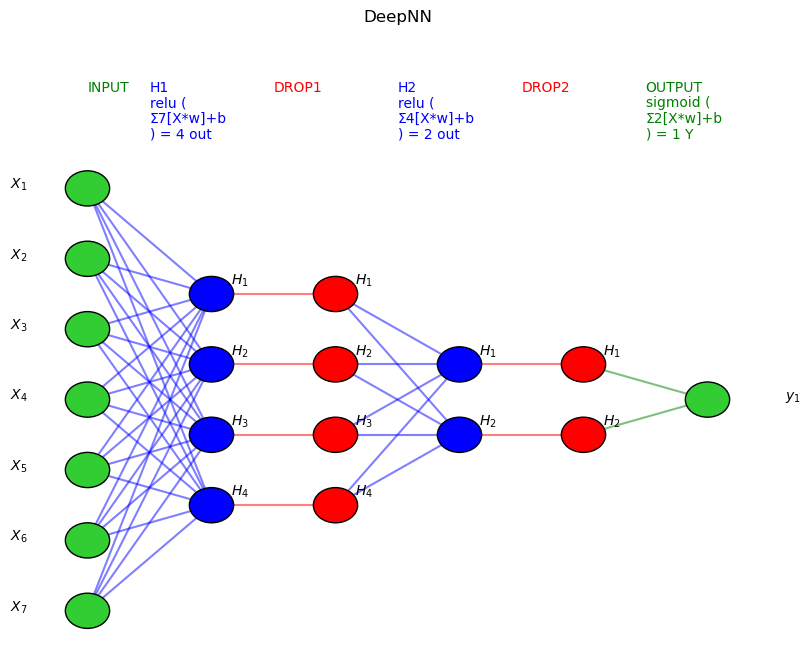

In [92]:
visualize_nn(model, description=True, figsize=(10,8))

In [93]:
utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [94]:
# define metrics
def Recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def Precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def F1(y_true, y_pred):
    precision = Precision(y_true, y_pred)
    recall = Recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the neural network
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',F1])

In [95]:
# define metrics
def R2(y, y_hat):
    ss_res =  K.sum(K.square(y - y_hat)) 
    ss_tot = K.sum(K.square(y - K.mean(y))) 
    return ( 1 - ss_res/(ss_tot + K.epsilon()) )

# compile the neural network
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[R2])

In [96]:

t_X_train = torch.from_numpy(train_data.values).float().to("cpu") #MPS
t_X_test = torch.from_numpy(X_test.values).float().to("cpu")
t_y_train = torch.from_numpy(train_labels.values).float().to("cpu")
t_y_test = torch.from_numpy(y_test.values).float().to("cpu")
#t_y_train = t_y_train[:,None]
#t_y_test = t_y_test[:, None]

In [97]:
def utils_plot_keras_training(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
    
    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()
    
    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()


def fit_dl_classif(X_train, y_train, X_test, model=None, batch_size=32, epochs=100, verbose=0, threshold=0.5):
    ## model
    if model is None:
        ### define F1 metrics for Keras
        def Recall(y, y_hat):
            true_positives = K.sum(K.round(K.clip(y * y_hat, 0, 1)))
            possible_positives = K.sum(K.round(K.clip(y, 0, 1)))
            recall = true_positives / (possible_positives + K.epsilon())
            return recall

        def Precision(y, y_hat):
            true_positives = K.sum(K.round(K.clip(y * y_hat, 0, 1)))
            predicted_positives = K.sum(K.round(K.clip(y_hat, 0, 1)))
            precision = true_positives / (predicted_positives + K.epsilon())
            return precision

        def F1(y, y_hat):
            precision = Precision(y, y_hat)
            recall = Recall(y, y_hat)
            return 2*((precision*recall)/(precision+recall+K.epsilon()))

        ### build ann
        n_features = X_train.shape[1]
        #### layer input
        inputs = layers.Input(name="input", shape=(n_features,))
        #### hidden layer 1
        h1 = layers.Dense(name="h1", units=int(round((n_features+1)/2)), activation='relu')(inputs)
        h1 = layers.Dropout(name="drop1", rate=0.2)(h1)
        #### hidden layer 2
        h2 = layers.Dense(name="h2", units=int(round((n_features+1)/4)), activation='relu')(h1)
        h2 = layers.Dropout(name="drop2", rate=0.2)(h2)
        #### layer output
        outputs = layers.Dense(name="output", units=1, activation='sigmoid')(h2)
        model = models.Model(inputs=inputs, outputs=outputs, name="DeepNN")
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',F1])
        print(model.summary())
    
    ## train
    training = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, shuffle=True, verbose=verbose, validation_split=0.3)
    if epochs > 1:
        utils_plot_keras_training(training)
    
    ## test
    predicted_prob = training.model.predict(X_test)
    predicted = (predicted_prob > threshold)
    return training.model, predicted_prob, predicted

In [98]:
"""
t_X_train = np.array(train_data)
t_X_test = np.array(X_test)
t_y_train = np.array(train_labels)
t_y_test = np.array(y_test)
t_y_train = t_y_train[:,None]
t_y_test = t_y_test[:, None]
"""

'\nt_X_train = np.array(train_data)\nt_X_test = np.array(X_test)\nt_y_train = np.array(train_labels)\nt_y_test = np.array(y_test)\nt_y_train = t_y_train[:,None]\nt_y_test = t_y_test[:, None]\n'

In [99]:
"""
model, predicted_prob, predicted = fit_dl_classif(t_X_train, t_y_train, t_X_test, model,batch_size=64, epochs=100, threshold=0.5)
"""

'\nmodel, predicted_prob, predicted = fit_dl_classif(t_X_train, t_y_train, t_X_test, model,batch_size=64, epochs=100, threshold=0.5)\n'

In [100]:
"""
def evaluate_classif_model(y_test, predicted, predicted_prob, show_thresholds=True, figsize=(25,5)):
    classes = np.unique(y_test)
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    
    ## Accuray e AUC
    accuracy = metrics.accuracy_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test, predicted_prob)
    print("Accuracy (overall correct predictions):",  round(accuracy,2))
    print("Auc:", round(auc,2))
    
    ## Precision e Recall
    recall = metrics.recall_score(y_test, predicted)  #= true 1s / all 1s in test (got and missed)
    precision = metrics.precision_score(y_test, predicted)  #= true 1s / all 1s predicted (true 1s + false 1s)
    f1 = metrics.f1_score(y_test, predicted)  #=2 * (precision * recall) / (precision + recall)
    print("Recall (all 1s predicted right):", round(recall,2))  #true positive rate, how many 1s I got
    print("Precision (confidence when predicting a 1):", round(precision,2))  #how many 1s were really 1s
    print("F1 score:", round(f1,2))
    print("Detail:")
    print(metrics.classification_report(y_test, predicted, target_names=[str(i) for i in classes]))
       
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(y_test, predicted, labels=classes)
    sns.heatmap(cm, annot=True, annot_kws={"size":15}, fmt='d', ax=ax[0], cmap=plt.cm.Blues, cbar=False)
    ax[0].set(xlabel="Pred", ylabel="True", title="Confusion matrix")
    ax[0].set_yticklabels(labels=classes, rotation=0)
 
    ## Plot roc
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_prob)    
    ax[1].plot(fpr, tpr, color='darkorange', lw=3, label='area = %0.2f' % metrics.auc(fpr, tpr))
    ax[1].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[1].hlines(y=recall, xmin=-0.05, xmax=1-cm[0,0]/(cm[0,0]+cm[0,1]), color='red', linestyle='--', alpha=0.7, label="chosen threshold")
    ax[1].vlines(x=1-cm[0,0]/(cm[0,0]+cm[0,1]), ymin=0, ymax=recall, color='red', linestyle='--', alpha=0.7)
    ax[1].set(xlim=[-0.05,1], ylim=[0.0,1.05], xlabel='False Positive Rate', ylabel="True Positive Rate (Recall)", title="Receiver operating characteristic")     
    ax[1].legend(loc="lower right")
    ax[1].grid(True)
    if show_thresholds is True:
        thres_in_plot = []
        for i,t in enumerate(thresholds):
            t = np.round(t,1)
            if t not in thres_in_plot:
                ax[1].annotate(t, xy=(fpr[i],tpr[i]), xytext=(fpr[i],tpr[i]), textcoords='offset points', ha='left', va='bottom')
                thres_in_plot.append(t)
    
    ## Plot precision-recall curve
    precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, predicted_prob)
    ax[2].plot(recalls, precisions, color='darkorange', lw=3, label='area = %0.2f' % metrics.auc(recalls, precisions))
    ax[2].plot([0,1], [(cm[1,0]+cm[1,0])/len(y_test), (cm[1,0]+cm[1,0])/len(y_test)], linestyle='--', color='navy', lw=3)
    ax[2].hlines(y=precision, xmin=0, xmax=recall, color='red', linestyle='--', alpha=0.7, label="chosen threshold")
    ax[2].vlines(x=recall, ymin=0, ymax=precision, color='red', linestyle='--', alpha=0.7)
    ax[2].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
    ax[2].legend(loc="lower left")
    ax[2].grid(True)
    if show_thresholds is True:
        thres_in_plot = []
        for i,t in enumerate(thresholds):
            t = np.round(t,1)
            if t not in thres_in_plot:
                ax[2].annotate(np.round(t,1), xy=(recalls[i],precisions[i]), xytext=(recalls[i],precisions[i]), textcoords='offset points', ha='right', va='bottom')
                thres_in_plot.append(t)

    plt.show()
    
"""

'\ndef evaluate_classif_model(y_test, predicted, predicted_prob, show_thresholds=True, figsize=(25,5)):\n    classes = np.unique(y_test)\n    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)\n    \n    ## Accuray e AUC\n    accuracy = metrics.accuracy_score(y_test, predicted)\n    auc = metrics.roc_auc_score(y_test, predicted_prob)\n    print("Accuracy (overall correct predictions):",  round(accuracy,2))\n    print("Auc:", round(auc,2))\n    \n    ## Precision e Recall\n    recall = metrics.recall_score(y_test, predicted)  #= true 1s / all 1s in test (got and missed)\n    precision = metrics.precision_score(y_test, predicted)  #= true 1s / all 1s predicted (true 1s + false 1s)\n    f1 = metrics.f1_score(y_test, predicted)  #=2 * (precision * recall) / (precision + recall)\n    print("Recall (all 1s predicted right):", round(recall,2))  #true positive rate, how many 1s I got\n    print("Precision (confidence when predicting a 1):", round(precision,2))  #how many 1s were really 

In [101]:
"""
evaluate_classif_model(y_test, predicted, predicted_prob, figsize=(25,5))
"""

'\nevaluate_classif_model(y_test, predicted, predicted_prob, figsize=(25,5))\n'

In [102]:
t_y_train

tensor([[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]])

In [103]:
class Red(nn.Module):
    
    def __init__(self, n_entradas):
        super(Red, self).__init__()
        self.linear1 = nn.Linear(n_entradas, 30)
        self.linear2 = nn.Linear(30, 160)
        self.linear3 = nn.Linear(160,1)
        #self.linear4 = nn.Linear(30, 1)
        #self.linear5 = nn.Linear(200, 1)
        #self.linear3 = nn.Linear(8, 1)
    
    def forward(self, inputs):
        pred_1 = torch.sigmoid(input=self.linear1(inputs))
        pred_2 = torch.sigmoid(input=self.linear2(pred_1))
        #pred_3 = torch.sigmoid(input=self.linear3(pred_2))
        #pred_4 = torch.sigmoid(input=self.linear4(pred_3))
        #pred_5 = torch.sigmoid(input=self.linear5(pred_4))
        pred_f = torch.sigmoid(input=self.linear3(pred_2))
        return pred_f

In [104]:
t_y_test[0]

tensor([0.])

In [105]:
n_entradas= train.shape[1]

In [106]:
t_y_train

tensor([[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]])

In [ ]:
lr = 0.001
epochs = 2000
estatus_print = 100

model = Red(n_entradas=n_entradas)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
print("Arquitectura del modelo: {}".format(model))
historico = pd.DataFrame()

print("Entranando el modelo")
for epoch in range(1, epochs+1):
    y_pred= model(t_X_train)
    loss = loss_fn(input=y_pred, target=t_y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if epoch % estatus_print == 0:
        print(f"\nEpoch {epoch} \t Loss: {round(loss.item(), 4)}")
    
    with torch.no_grad():
        y_pred = model(t_X_test)
        y_pred_class = y_pred.round()
        correct = (y_pred_class == t_y_test).sum()
        accuracy = 100 * correct / float(len(t_y_test))
        if epoch % estatus_print == 0:
            print("Accuracy: {}".format(accuracy.item()))
    
    df_tmp = pd.DataFrame(data={
        'Epoch': epoch,
        'Loss': round(loss.item(), 4),
        'Accuracy': round(accuracy.item(), 4)
    }, index=[0])
    historico = pd.concat(objs=[historico, df_tmp], ignore_index=True, sort=False)

print("Accuracy final: {}".format(round(accuracy.item(), 4)))

Arquitectura del modelo: Red(
  (linear1): Linear(in_features=7, out_features=30, bias=True)
  (linear2): Linear(in_features=30, out_features=160, bias=True)
  (linear3): Linear(in_features=160, out_features=1, bias=True)
)
Entranando el modelo

Epoch 100 	 Loss: 0.0197
Accuracy: 9.26511001586914

Epoch 200 	 Loss: 0.0139
Accuracy: 9.26511001586914


In [1]:
plt.figure(figsize=(10, 10))
plt.plot(historico['Epoch'], historico['Loss'], label='Loss')
plt.title("Loss", fontsize=25)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid()
plt.show()

NameError: name 'plt' is not defined

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(historico['Epoch'], historico['Accuracy'], label='Accuracy')
plt.title("Accuracy", fontsize=25)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid()
plt.show()